<b>Obesity research in specialty journals from 2000 to 2023: A bibliometric analysis</b>
<br>(Python code based on: Almenara (2022) https://doi.org/10.1371/journal.pone.0278981)

In [ ]:
! pip install gensim spacy scispacy
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_lg-0.5.4.tar.gz

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_lg-0.5.4.tar.gz (531.2 MB)
  Preparing metadata (setup.py) ... done


In [ ]:
import os
import re
from google.colab import drive
import pickle
import pandas as pd
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the main Google Drive directory path for all exports
input_dir = '/content/drive/My Drive/DATASETS/OBESITY.JOURNALS/'
output_dir = '/content/drive/My Drive/DATASETS/OBESITY.JOURNALS/topic_modeling'

In [ ]:
# Loading our collection of bibliographic records gathered from Dimensions.ai
"""
NOTE: Due to copyright is not possible to share this dataset
To replicate the download of this dataset read the procedure in the paper
associated to this code.
"""
filename = os.path.join(input_dir, 'merged_results_filtered.csv')
df = pd.read_csv(filename)
df.head()

,id,funders,abstract,category_bra,category_for,category_hra,category_hrcs_hc,category_rcdc,category_sdg,category_uoa,...,pages,type,year,journal.id,journal.title,volume,issue,authors_count,concepts_scores,issn
0,pub.1000391299,NaN,IntroductionIrisin is a myokine secreted from ...,"[{'id': '4001', 'name': 'Clinical Medicine and...","[{'id': '80003', 'name': '32 Biomedical and Cl...","[{'id': '3901', 'name': 'Clinical'}]","[{'id': '906', 'name': 'Metabolic and endocrin...","[{'id': '612', 'name': 'Physical Activity'}, {...",NaN,"[{'id': '30024', 'name': 'C24 Sport and Exerci...",...,15-20,article,2016.0,jour.1155510,Obesity Medicine,1.0,NaN,2,"[{'concept': 'sedentary young women', 'relevan...",24518476
1,pub.1007273132,"[{'acronym': 'ESE', 'city_name': 'Bristol', 'c...","Hormones encoded by the ghrelin gene, GHRL, re...","[{'id': '4000', 'name': 'Basic Science'}]","[{'id': '80051', 'name': '3208 Medical Physiol...",NaN,"[{'id': '894', 'name': 'Cardiovascular'}, {'id...","[{'id': '507', 'name': 'Clinical Research'}, {...",NaN,"[{'id': '30001', 'name': 'A01 Clinical Medicin...",...,1-3,article,2017.0,jour.1155510,Obesity Medicine,5.0,NaN,5,"[{'concept': 'ghrelin gene expression', 'relev...",24518476
2,pub.1007962492,NaN,PurposeThe aim of this study was to clarify th...,"[{'id': '4001', 'name': 'Clinical Medicine and...","[{'id': '80003', 'name': '32 Biomedical and Cl...","[{'id': '3901', 'name': 'Clinical'}]","[{'id': '906', 'name': 'Metabolic and endocrin...","[{'id': '438', 'name': 'Diabetes'}, {'id': '38...",NaN,"[{'id': '30002', 'name': 'A02 Public Health, H...",...,1-5,article,2016.0,jour.1155510,Obesity Medicine,1.0,NaN,6,"[{'concept': 'type 2 diabetic patients', 'rele...",24518476
3,pub.1009717273,"[{'acronym': 'CNPq', 'city_name': 'Brasília', ...",AimsConsidering the protective role of adipone...,"[{'id': '4001', 'name': 'Clinical Medicine and...","[{'id': '80056', 'name': '3213 Paediatrics'}, ...",NaN,"[{'id': '906', 'name': 'Metabolic and endocrin...","[{'id': '389', 'name': 'Obesity'}, {'id': '308...",NaN,"[{'id': '30003', 'name': 'A03 Allied Health Pr...",...,4-10,article,2017.0,jour.1155510,Obesity Medicine,5.0,NaN,13,"[{'concept': 'biomarkers of inflammation', 're...",24518476
4,pub.1012242667,"[{'acronym': 'EC', 'city_name': 'Brussels', 'c...",BackgroundThe relation between area-level soci...,"[{'id': '4003', 'name': 'Public Health'}]","[{'id': '80003', 'name': '32 Biomedical and Cl...","[{'id': '3903', 'name': 'Population & Society'}]","[{'id': '906', 'name': 'Metabolic and endocrin...","[{'id': '389', 'name': 'Obesity'}, {'id': '558...",NaN,"[{'id': '30003', 'name': 'A03 Allied Health Pr...",...,13-18,article,2016.0,jour.1155510,Obesity Medicine,2.0,NaN,5,[{'concept': 'area-level socio-economic status...,24518476


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30061 entries, 0 to 30060
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    30061 non-null  object 
 1   funders               15962 non-null  object 
 2   abstract              30061 non-null  object 
 3   category_bra          24511 non-null  object 
 4   category_for          30057 non-null  object 
 5   category_hra          23646 non-null  object 
 6   category_hrcs_hc      21569 non-null  object 
 7   category_rcdc         29610 non-null  object 
 8   category_sdg          5844 non-null   object 
 9   category_uoa          30042 non-null  object 
 10  category_hrcs_rac     14285 non-null  object 
 11  category_icrp_cso     3628 non-null   object 
 12  category_icrp_ct      5293 non-null   object 
 13  recent_citations      30061 non-null  float64
 14  reference_ids         29562 non-null  object 
 15  concepts           

In [ ]:
# Let's check for unique values
df['abstract'].describe(include='all')

,abstract
count,30061
unique,30047
top,An amendment to this paper has been published ...
freq,5


In [ ]:
# Let's drop duplicates from the 'Abstract' column:
df.drop_duplicates(['abstract'], inplace=True)
# Let's remove cells with no abstract available:
df = df[df.abstract != 'An amendment to this paper has been published and can be accessed via a link at the top of the paper.']
df['abstract'].describe(include='all')

,abstract
count,30046
unique,30046
top,IntroductionIrisin is a myokine secreted from ...
freq,1


In [ ]:
# Removing NaNs (if any)
# implace=True to keep the df with valid entries in the same variable.
df.dropna(subset=['abstract'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30046 entries, 0 to 30060
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    30046 non-null  object 
 1   funders               15960 non-null  object 
 2   abstract              30046 non-null  object 
 3   category_bra          24501 non-null  object 
 4   category_for          30042 non-null  object 
 5   category_hra          23640 non-null  object 
 6   category_hrcs_hc      21563 non-null  object 
 7   category_rcdc         29597 non-null  object 
 8   category_sdg          5840 non-null   object 
 9   category_uoa          30028 non-null  object 
 10  category_hrcs_rac     14282 non-null  object 
 11  category_icrp_cso     3626 non-null   object 
 12  category_icrp_ct      5288 non-null   object 
 13  recent_citations      30046 non-null  float64
 14  reference_ids         29556 non-null  object 
 15  concepts              30

In [ ]:
# There are 'attached' words (e.g., 'IntroductionThe')
print(df['abstract'][:5])

0    IntroductionIrisin is a myokine secreted from ...
1    Hormones encoded by the ghrelin gene, GHRL, re...
2    PurposeThe aim of this study was to clarify th...
3    AimsConsidering the protective role of adipone...
4    BackgroundThe relation between area-level soci...
Name: abstract, dtype: object


In [ ]:
# Let's separate those concatened words in the abstract
def separate_abstract_subheadings(text):
    """
    Separates concatenated structured abstract subheadings from following words.
    Common issue: "IntroductionIrisin" → "Introduction Irisin"
    Parameters: text (str): Abstract text with potential concatenated subheadings
    Returns:
    str: Text with properly separated subheadings
    """
    if not isinstance(text, str):
        return text

    # Common structured abstract subheadings (comprehensive list)
    subheadings = [
        # Introduction variants
        'Introduction', 'Background', 'Context', 'Rationale', 'Premise',
        # Purpose/Objective variants
        'Purpose', 'Objective', 'Objectives', 'Aim', 'Aims', 'Goal', 'Goals',
        'Hypothesis', 'Research question', 'Research questions',
        # Methods variants
        'Methods', 'Methodology', 'Material and methods', 'Materials and methods',
        'Procedures', 'Procedure', 'Design', 'Study design', 'Approach',
        'Participants', 'Setting', 'Intervention', 'Interventions',
        # Results variants
        'Results', 'Result', 'Findings', 'Main findings', 'Key findings',
        'Outcomes', 'Main outcomes', 'Primary outcomes', 'Secondary outcomes',
        'Measurements', 'Main outcome measures',
        # Discussion/Conclusion variants
        'Discussion', 'Conclusion', 'Conclusions', 'Summary',
        'Principal conclusions', 'Main conclusions', 'Key conclusions',
        'Implications', 'Clinical implications', 'Practical implications',
        'Significance', 'Clinical significance', 'Trial registration'
    ]

    # Create regex patterns for each subheading
    # Pattern looks for: subheading + capital letter (start of next word)
    for subheading in subheadings:
        # Case-insensitive pattern: subheading followed by capital letter or number
        # Uses word boundary at start to avoid partial matches
        pattern = rf'\b({re.escape(subheading)})([A-Z][a-z]|\d)'
        replacement = r'\1 \2'
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

    # Additional pattern for common combinations with "and"
    # e.g., "Material and methodsThe" → "Material and methods The"
    compound_patterns = [
        (r'\b(Material and method)([A-Z][a-z]|\d)', r'\1 \2'),
        (r'\b(Material and methods)([A-Z][a-z]|\d)', r'\1 \2'),
        (r'\b(Materials and methods)([A-Z][a-z]|\d)', r'\1 \2'),
        (r'\b(Research questions?)([A-Z][a-z]|\d)', r'\1 \2'),
        (r'\b(Main outcome measures?)([A-Z][a-z]|\d)', r'\1 \2'),
        (r'\b(Trial registration)([A-Z][a-z]|\d)', r'\1 \2'),
        (r'\b(Study design)([A-Z][a-z]|\d)', r'\1 \2'),
        (r'\b(Primary outcomes?)([A-Z][a-z]|\d)', r'\1 \2'),
        (r'\b(Secondary outcomes?)([A-Z][a-z]|\d)', r'\1 \2'),
        (r'\b(Clinical implications?)([A-Z][a-z]|\d)', r'\1 \2'),
        (r'\b(Practical implications?)([A-Z][a-z]|\d)', r'\1 \2'),
        (r'\b(Clinical significance)([A-Z][a-z]|\d)', r'\1 \2'),
        (r'\b(Principal conclusions?)([A-Z][a-z]|\d)', r'\1 \2'),
        (r'\b(Main conclusions?)([A-Z][a-z]|\d)', r'\1 \2'),
        (r'\b(Key conclusions?)([A-Z][a-z]|\d)', r'\1 \2'),
        (r'\b(Main findings?)([A-Z][a-z]|\d)', r'\1 \2'),
        (r'\b(Key findings?)([A-Z][a-z]|\d)', r'\1 \2'),
        (r'\b(Main outcomes?)([A-Z][a-z]|\d)', r'\1 \2')
    ]

    for pattern, replacement in compound_patterns:
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

    return text

def process_dataframe_abstracts(df, abstract_column='abstract'):
    """
    Apply subheading separation to all abstracts in a DataFrame
    """
    if abstract_column not in df.columns:
        raise ValueError(f"Column '{abstract_column}' not found in DataFrame")

    print(f"Processing {len(df)} abstracts...")

    # Apply the separation function to all abstracts
    df[abstract_column] = df[abstract_column].apply(separate_abstract_subheadings)

    print("Abstract subheading separation completed!")
    return df

In [ ]:
%%time
print("Before processing - sample abstract:")
print(df['abstract'].iloc[:5][:100])  # Show first 100 chars of first 5 abstracts

# Apply the subheading separation
df = process_dataframe_abstracts(df, abstract_column='abstract')

print("\nAfter processing - sample abstract:")
print(df['abstract'].iloc[:5][:100])  # Show result

Before processing - sample abstract:
0    IntroductionIrisin is a myokine secreted from ...
1    Hormones encoded by the ghrelin gene, GHRL, re...
2    PurposeThe aim of this study was to clarify th...
3    AimsConsidering the protective role of adipone...
4    BackgroundThe relation between area-level soci...
Name: abstract, dtype: object
Processing 30046 abstracts...
Abstract subheading separation completed!

After processing - sample abstract:
0    Introduction Irisin is a myokine secreted from...
1    Hormones encoded by the ghrelin gene, GHRL, re...
2    Purpose The aim of this study was to clarify t...
3    Aim sConsidering the protective role of adipon...
4    Background The relation between area-level soc...
Name: abstract, dtype: object
CPU times: user 1min 30s, sys: 300 ms, total: 1min 31s
Wall time: 1min 34s


In [ ]:
# Now, let's add a word count column into our df
df['abstract_word_count'] = df['abstract'].apply(lambda x: len(str(x).split()))
print(df['abstract_word_count'].describe(include='all'))

count    30046.000000
mean       226.735306
std         57.029638
min          1.000000
25%        200.000000
50%        233.000000
75%        258.000000
max        858.000000
Name: abstract_word_count, dtype: float64


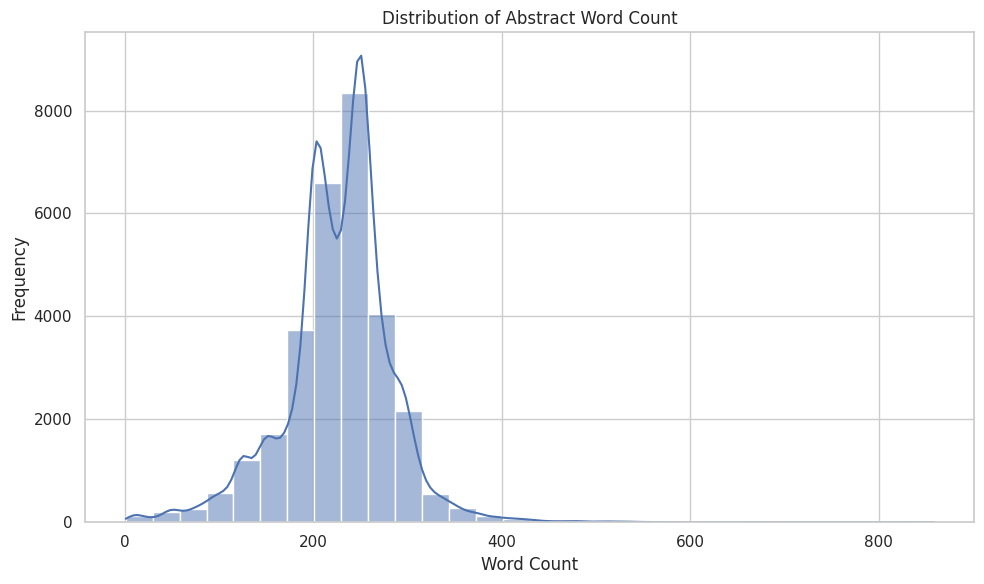

In [ ]:
# There are outliers, so let's evaluate the distribution of word counts
import seaborn as sns
# Set the style for the plot
sns.set(style="whitegrid")

# Plot the distribution
plt.figure(figsize=(10, 6))
# 'kde' adds a Kernel Density Estimate line to show the smoothed distribution curve:
sns.histplot(df['abstract_word_count'], bins=30, kde=True) # 'bins' sets the number of histogram bins

# Add labels and title
plt.title('Distribution of Abstract Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Let's filter rows in which abstract word count is < (mean - 2*SD)
# Identify rows where abstract_word_count is less than 55
filtering_df = df[df['abstract_word_count'] < 55]
print(f"Number of rows with abstract word count < 55: {len(filtering_df)}")
filtering_df.head()

Number of rows with abstract word count < 55: 293


,id,funders,abstract,category_bra,category_for,category_hra,category_hrcs_hc,category_rcdc,category_sdg,category_uoa,...,type,year,journal.id,journal.title,volume,issue,authors_count,concepts_scores,issn,abstract_word_count
1,pub.1007273132,"[{'acronym': 'ESE', 'city_name': 'Bristol', 'c...","Hormones encoded by the ghrelin gene, GHRL, re...","[{'id': '4000', 'name': 'Basic Science'}]","[{'id': '80051', 'name': '3208 Medical Physiol...",NaN,"[{'id': '894', 'name': 'Cardiovascular'}, {'id...","[{'id': '507', 'name': 'Clinical Research'}, {...",NaN,"[{'id': '30001', 'name': 'A01 Clinical Medicin...",...,article,2017.0,jour.1155510,Obesity Medicine,5.0,NaN,5,"[{'concept': 'ghrelin gene expression', 'relev...",24518476,47
7,pub.1017815504,NaN,Obesity is linked to several comorbidities and...,"[{'id': '4003', 'name': 'Public Health'}]","[{'id': '80003', 'name': '32 Biomedical and Cl...","[{'id': '3901', 'name': 'Clinical'}]","[{'id': '906', 'name': 'Metabolic and endocrin...","[{'id': '388', 'name': 'Nutrition'}, {'id': '3...",NaN,"[{'id': '30004', 'name': 'A04 Psychology, Psyc...",...,article,2016.0,jour.1155510,Obesity Medicine,4.0,NaN,2,"[{'concept': 'unhealthy behaviors', 'relevance...",24518476,48
19,pub.1043707809,NaN,"A total of 83 centrally obese adults, 46 of wh...","[{'id': '4001', 'name': 'Clinical Medicine and...","[{'id': '80141', 'name': '4206 Public Health'}...",NaN,NaN,"[{'id': '389', 'name': 'Obesity'}, {'id': '388...",NaN,"[{'id': '30006', 'name': 'A06 Agriculture, Vet...",...,article,2016.0,jour.1155510,Obesity Medicine,3.0,NaN,5,"[{'concept': 'centrally obese adults', 'releva...",24518476,50
28,pub.1084099872,"[{'acronym': 'NHMRC', 'city_name': 'Canberra',...",This study examined whether intermittent fasti...,"[{'id': '4001', 'name': 'Clinical Medicine and...","[{'id': '80003', 'name': '32 Biomedical and Cl...",NaN,"[{'id': '906', 'name': 'Metabolic and endocrin...","[{'id': '438', 'name': 'Diabetes'}, {'id': '38...",NaN,"[{'id': '30003', 'name': 'A03 Allied Health Pr...",...,article,2017.0,jour.1155510,Obesity Medicine,6.0,NaN,13,"[{'concept': 'metabolic parameters', 'relevanc...",24518476,50
143,pub.1122778238,"[{'acronym': 'NIDDK', 'city_name': 'Bethesda',...",We examined the personal dietary weight-loss s...,"[{'id': '4001', 'name': 'Clinical Medicine and...","[{'id': '80003', 'name': '32 Biomedical and Cl...",NaN,NaN,"[{'id': '430', 'name': 'Complementary and Inte...",NaN,"[{'id': '30003', 'name': 'A03 Allied Health Pr...",...,article,2020.0,jour.1155510,Obesity Medicine,17.0,NaN,3,"[{'concept': 'dietary weight loss strategy', '...",24518476,48


In [ ]:
# After inspectio of the dataset, I decided to remove those with < 30 words
# Most of them say 'A Correction to this paper has been published...'
df = df[df['abstract_word_count'] >= 30]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29922 entries, 0 to 30060
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    29922 non-null  object 
 1   funders               15944 non-null  object 
 2   abstract              29922 non-null  object 
 3   category_bra          24447 non-null  object 
 4   category_for          29922 non-null  object 
 5   category_hra          23631 non-null  object 
 6   category_hrcs_hc      21533 non-null  object 
 7   category_rcdc         29508 non-null  object 
 8   category_sdg          5826 non-null   object 
 9   category_uoa          29912 non-null  object 
 10  category_hrcs_rac     14274 non-null  object 
 11  category_icrp_cso     3622 non-null   object 
 12  category_icrp_ct      5259 non-null   object 
 13  recent_citations      29922 non-null  float64
 14  reference_ids         29516 non-null  object 
 15  concepts              29

## **EVIDENCE-BASED TOPIC MODELING METHODOLOGY**

### **Recommended Best Practices for Bibliometric Topic Modeling**

Based on recent literature (Churchill & Singh, 2022; Kherwa & Bansal, 2020; Vayansky & Kumar, 2020):

**1. Text Preprocessing Pipeline Order:**
- Lowercasing and punctuation removal ✓
- Stopword removal (iterative approach) ✓
- **First**: Create bigrams → **Then**: Create trigrams ✓
- Lemmatization (keeping NOUN, ADJ, VERB, ADV) ✓
- Minimum word frequency filtering ✓

**2. Stopwords Strategy:**
- Standard linguistic stopwords (spaCy + scikit-learn)
- Domain-specific academic stopwords
- Statistical removal (words in >95% of documents)
- Iterative refinement based on initial topic results

**3. N-gram Creation:**
- **Evidence**: Bigrams should be created first, then trigrams
- **Rationale**: Allows trigram detection to build upon established bigram patterns
- **Parameters**: min_count=5, threshold=100 (reasonable for large corpora)

**4. TF-IDF Parameters:**
- max_df=0.95 (remove words in >95% of documents)
- min_df=2 (require word to appear in at least 2 documents)
- max_features=None (let data determine vocabulary size)

**5. NMF Parameters:**
- Use 'nndsvd' initialization for reproducibility
- Set random_state for reproducibility
- Use l1_ratio=0.5 for sparse solutions

<b>NATURAL LANGUAGE PROCESSING (NLP)</b>

In [ ]:
# scispaCy - We will use AllenAI 'en_core_sci_lg' model
nlp = en_core_sci_lg.load()
nlp.max_length = 100000000

/usr/local/lib/python3.11/dist-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [ ]:
# STOPWORDS: spaCy + Custom (based on author's domain knowledge)
stopwords = list(STOP_WORDS)

stopwords.extend([ 'doi', 'inc', 'pmc', 'www', 'ltd', 'fig', 'llc',
                   'org', 'https', 'et', 'al', 'peer', 'sons',
                   'used', 'using', 'license', 'rights', 'reserved',
                   'permission', 'copyright', 'john', 'wiley', 'elsevier',
                   'periodical', 'preprint', 'reviewed', 'author', 'review'
                   'abstract', 'background', 'purpose', 'objective',
                   'available', 'study', 'research', 'figure', 'literature',
                   'american', 'association', 'company', 'version', 'taylor',
                   'francis', 'springer', 'switzerland', 'international',
                   'published', 'publishing', 'obesity', 'obese',
                   'chinese', 'italian', 'portuguese', 'overweight',
                   'introduction', 'aim', 'original', 'article',
                   'unfortunately', 'contained', 'result',
                   'error', 'mistake', 'nature', 'fulltext',
                   'science', 'business', 'media'
                    ])

stopwords.sort()
print(stopwords)

["'d", "'ll", "'m", "'re", "'s", "'ve", 'a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'aim', 'al', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'american', 'among', 'amongst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'article', 'as', 'association', 'at', 'author', 'available', 'back', 'background', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'both', 'bottom', 'business', 'but', 'by', 'ca', 'call', 'can', 'cannot', 'chinese', 'company', 'contained', 'copyright', 'could', 'did', 'do', 'does', 'doi', 'doing', 'done', 'down', 'due', 'during', 'each', 'eight', 'either', 'eleven', 'else', 'elsevier', 'elsewhere', 'empty', 'enough', 'error', 'et', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'f

In [ ]:
data = (df['abstract'].to_list())
data[:5]

['Introduction Irisin is a myokine secreted from the muscle in response to exercise. The aim of this study was to investigate the acute and chronic effect of resistance training in sedentary young women.Material and methods In this study, 21 sedentary young women with range of 20–30 years and BMI 22–25\xa0kg/m2 were selected by convenience sampling. Then, the volunteers were randomly assigned into two groups. The selected training was comprised of 8 weeks, 3 times a week. Blood samples were obtained at baseline, after one session and 48\xa0h at the end of the study. For all statistical comparisons, the level of significance was considered P\xa0<\xa00.05.Result The results of this study showed that the levels of Irisin, body mass index, and body fat percentage in the low-intensity training group were not significant (P\xa0>\xa00.05). Moreover, no significant changes were shown in body mass index and body fat percentage in high-intensity training (P\xa0>\xa00.05). In contrast, the levels

In [ ]:
# Define functions for simple preprocessing, stopwords, bigrams, trigrams and lemmatization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Creating a list of lists
data_words = list(sent_to_words(data))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# EVIDENCE-BASED N-GRAM CREATION
# Following best practices: Create bigrams first, then trigrams
# This allows trigrams to build upon established bigram patterns

# Parameters based on Kherwa & Bansal (2020) recommendations:
# - min_count=5: Minimum frequency for phrase inclusion (filters noise)
# - threshold=100: Higher values = more selective phrase detection
# - For large corpora (>10k docs), these values provide good balance

# Step 1: Create bigram model first
bigram = Phrases(data_words, min_count=5, threshold=100)
bigram_mod = Phraser(bigram)

# Step 2: Create trigram model using bigram-processed data
# This is the CORRECT order - trigrams build upon bigrams
trigram = Phrases(bigram[data_words], threshold=100)
trigram_mod = Phraser(trigram)

In [ ]:
# Let's see bigram/trigram examples
print(trigram_mod[bigram_mod[data_words[0]]])

['introduction', 'irisin', 'is', 'myokine', 'secreted', 'from', 'the', 'muscle', 'in', 'response', 'to', 'exercise', 'the', 'aim', 'of', 'this', 'study', 'was', 'to', 'investigate', 'the', 'acute', 'and', 'chronic', 'effect', 'of', 'resistance', 'training', 'in', 'sedentary', 'young', 'women', 'material', 'and', 'methods', 'in', 'this', 'study', 'sedentary', 'young', 'women', 'with', 'range', 'of', 'years', 'and', 'bmi', 'kg', 'were', 'selected', 'by', 'convenience_sampling', 'then', 'the', 'volunteers', 'were', 'randomly_assigned', 'into', 'two', 'groups', 'the', 'selected', 'training', 'was', 'comprised', 'of', 'weeks', 'times', 'week', 'blood_samples', 'were', 'obtained', 'at', 'baseline', 'after', 'one', 'session', 'and', 'at', 'the', 'end', 'of', 'the', 'study', 'for', 'all', 'statistical', 'comparisons', 'the', 'level', 'of', 'significance', 'was', 'considered', 'result', 'the', 'results', 'of', 'this', 'study', 'showed', 'that', 'the', 'levels', 'of', 'irisin', 'body', 'mass', '

In [ ]:
%%time
# Removing Stop Words
data_words_nostops = remove_stopwords(data_words)

# Forming Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Forming Trigrams
data_words_trigrams = make_trigrams(data_words_bigrams)

CPU times: user 53 s, sys: 930 ms, total: 53.9 s
Wall time: 55 s


In [ ]:
%%time
# Lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

CPU times: user 15min 42s, sys: 2.74 s, total: 15min 45s
Wall time: 16min


In [ ]:
print(data_lemmatized[:2])

[['irisin', 'myokine', 'secrete', 'muscle', 'response', 'exercise', 'investigate', 'acute', 'chronic', 'effect', 'resistance', 'training', 'sedentary', 'young', 'woman', 'material', 'method', 'sedentary', 'young', 'woman', 'range', 'year', 'bmi', 'kg', 'select', 'convenience_sample', 'volunteer', 'randomly_assigned', 'group', 'select', 'training', 'comprised', 'week', 'time', 'week', 'blood_sample', 'obtain', 'baseline', 'session', 'end', 'statistical', 'comparison', 'level', 'significance', 'consider', 'result', 'show', 'level', 'irisin', 'body', 'mass', 'index', 'body', 'fat', 'percentage', 'low', 'intensity', 'training', 'group', 'significant', 'significant', 'change', 'show', 'body', 'mass', 'index', 'body', 'fat', 'percentage', 'high', 'intensity', 'training', 'contrast', 'level', 'irisin', 'high', 'intensity', 'training', 'decrease', 'significantly', 'low', 'intensity', 'rt', 'group', 'high', 'intensity', 'rt', 'group', 'significant', 'change', 'observe', 'serum', 'irisin', 'sess

In [ ]:
# Adding our list of lists into our data frame:
df['processed_list'] = data_lemmatized

In [ ]:
print(df["processed_list"][:10])

0    [irisin, myokine, secrete, muscle, response, e...
1    [hormone, encode, ghrelin, gene, ghrl, regulat...
2    [clarify, effect, diabetic, microvascular, com...
3    [sconsidere, protective, role, adiponectin, ed...
4    [relation, area, level, socio_economic_status,...
5    [investigate, people, diabetes_mellitus, dm, d...
6    [prevalence, underweight, employee, university...
7    [link, comorbiditie, involvement, unhealthy, b...
8    [global, health, problem, strong, risk, factor...
9    [aim, food, industry, responsibility, global, ...
Name: processed_list, dtype: object


In [ ]:
# Define function to convert our list of lists in raw text:
def text_clean(my_text):
    return [" ".join(i) for i in my_text]

In [ ]:
df['processed'] = text_clean(data_lemmatized)

In [ ]:
df.head()

,id,funders,abstract,category_bra,category_for,category_hra,category_hrcs_hc,category_rcdc,category_sdg,category_uoa,...,journal.id,journal.title,volume,issue,authors_count,concepts_scores,issn,abstract_word_count,processed_list,processed
0,pub.1000391299,NaN,Introduction Irisin is a myokine secreted from...,"[{'id': '4001', 'name': 'Clinical Medicine and...","[{'id': '80003', 'name': '32 Biomedical and Cl...","[{'id': '3901', 'name': 'Clinical'}]","[{'id': '906', 'name': 'Metabolic and endocrin...","[{'id': '612', 'name': 'Physical Activity'}, {...",NaN,"[{'id': '30024', 'name': 'C24 Sport and Exerci...",...,jour.1155510,Obesity Medicine,1.0,NaN,2,"[{'concept': 'sedentary young women', 'relevan...",24518476,253,"[irisin, myokine, secrete, muscle, response, e...",irisin myokine secrete muscle response exercis...
1,pub.1007273132,"[{'acronym': 'ESE', 'city_name': 'Bristol', 'c...","Hormones encoded by the ghrelin gene, GHRL, re...","[{'id': '4000', 'name': 'Basic Science'}]","[{'id': '80051', 'name': '3208 Medical Physiol...",NaN,"[{'id': '894', 'name': 'Cardiovascular'}, {'id...","[{'id': '507', 'name': 'Clinical Research'}, {...",NaN,"[{'id': '30001', 'name': 'A01 Clinical Medicin...",...,jour.1155510,Obesity Medicine,5.0,NaN,5,"[{'concept': 'ghrelin gene expression', 'relev...",24518476,47,"[hormone, encode, ghrelin, gene, ghrl, regulat...",hormone encode ghrelin gene ghrl regulate body...
2,pub.1007962492,NaN,Purpose The aim of this study was to clarify t...,"[{'id': '4001', 'name': 'Clinical Medicine and...","[{'id': '80003', 'name': '32 Biomedical and Cl...","[{'id': '3901', 'name': 'Clinical'}]","[{'id': '906', 'name': 'Metabolic and endocrin...","[{'id': '438', 'name': 'Diabetes'}, {'id': '38...",NaN,"[{'id': '30002', 'name': 'A02 Public Health, H...",...,jour.1155510,Obesity Medicine,1.0,NaN,6,"[{'concept': 'type 2 diabetic patients', 'rele...",24518476,192,"[clarify, effect, diabetic, microvascular, com...",clarify effect diabetic microvascular complica...
3,pub.1009717273,"[{'acronym': 'CNPq', 'city_name': 'Brasília', ...",Aim sConsidering the protective role of adipon...,"[{'id': '4001', 'name': 'Clinical Medicine and...","[{'id': '80056', 'name': '3213 Paediatrics'}, ...",NaN,"[{'id': '906', 'name': 'Metabolic and endocrin...","[{'id': '389', 'name': 'Obesity'}, {'id': '308...",NaN,"[{'id': '30003', 'name': 'A03 Allied Health Pr...",...,jour.1155510,Obesity Medicine,5.0,NaN,13,"[{'concept': 'biomarkers of inflammation', 're...",24518476,199,"[sconsidere, protective, role, adiponectin, ed...",sconsidere protective role adiponectin ed inve...
4,pub.1012242667,"[{'acronym': 'EC', 'city_name': 'Brussels', 'c...",Background The relation between area-level soc...,"[{'id': '4003', 'name': 'Public Health'}]","[{'id': '80003', 'name': '32 Biomedical and Cl...","[{'id': '3903', 'name': 'Population & Society'}]","[{'id': '906', 'name': 'Metabolic and endocrin...","[{'id': '389', 'name': 'Obesity'}, {'id': '558...",NaN,"[{'id': '30003', 'name': 'A03 Allied Health Pr...",...,jour.1155510,Obesity Medicine,2.0,NaN,5,[{'concept': 'area-level socio-economic status...,24518476,199,"[relation, area, level, socio_economic_status,...",relation area level socio_economic_status ses ...


In [ ]:
# Now let's create a column counting unique words in processed abstracts
df['unique_words_count'] = df['processed'].apply(lambda x: len(set(str(x).lower().split())))
print(df['unique_words_count'].describe(include='all'))

count    29922.000000
mean        74.586425
std         17.119814
min          7.000000
25%         64.000000
50%         74.000000
75%         85.000000
max        238.000000
Name: unique_words_count, dtype: float64


In [ ]:
# Saving our data frame
pkl_filename = os.path.join(output_dir, 'df_processed.pkl')
df.to_pickle(pkl_filename)
'''
# To load it:
pkl_filename = os.path.join(output_dir, 'df_processed.pkl')
with open(pkl_filename, 'rb') as f:
    df = pickle.load(f)
'''

<b>TOPIC MODELING WITH SCI-KIT LEARN NMF</b>

We will be using SciKitLearn to perform:
Non-Negative Matrix Factorization (based on TF-IDF)
https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [ ]:
# We create this numpy array object for our analyses
processed_text = df['processed'].values

In [ ]:
# EVIDENCE-BASED TF-IDF VECTORIZATION FOR NMF
# Parameters following established practices in bibliometric topic modeling:

# max_df=0.95: Remove words appearing in >95% of documents (too common)
# min_df=2: Words must appear in at least 2 documents (reduces noise)
# max_features=None: Let data determine vocabulary size (recommended for scientific corpora)
# ngram_range=(1,1): Already handled with Gensim
# sublinear_tf=True: Apply log scaling to term frequencies (handles skewed distributions)

tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,           # Remove ubiquitous terms
    min_df=2,              # Remove extremely rare terms
    max_features=None,     # No vocabulary size limit
    ngram_range=(1, 1),    # Unigrams only because already handled with Gensim
    sublinear_tf=True,     # Log-scale term frequencies
    stop_words=None        # We've already handled stopwords
)

In [ ]:
%%time
tfidf = tfidf_vectorizer.fit_transform(processed_text)

CPU times: user 2.99 s, sys: 131 ms, total: 3.12 s
Wall time: 3.13 s


In [ ]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [ ]:
display(tfidf.shape)

(29922, 27736)

In [ ]:
# DEFINE THE COHERENCE CALCULATION FUNCTION
def calculate_coherence_alternative(model, vectorizer, num_top_words=10):
    """
    Coherence calculation
    """
    try:
        # Get feature names
        feature_names = vectorizer.get_feature_names_out()

        # Extract topics
        topics = []
        for topic in model.components_:
            top_words = [feature_names[i] for i in topic.argsort()[-num_top_words:][::-1]]
            topics.append(top_words)

        # Prepare texts for coherence (split processed text)
        texts = [text.split() for text in processed_text]

        # Create dictionary
        dictionary = Dictionary(texts)

        # Calculate coherence
        coherence_model = CoherenceModel(
            topics=topics,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )

        return coherence_model.get_coherence()

    except Exception as e:
        print(f"Coherence calculation failed: {e}")
        return 0.0

In [ ]:
# TOPIC NUMBER OPTIMIZATION (k=5 to 21)
def optimize_topic_number(vectorized_data, text_data, vectorizer, k_range=range(5, 22)):  # 22 to include 21
    """
    Systematic approach to determine optimal number of topics
    Using the working alternative coherence calculation
    """
    coherence_scores = []
    reconstruction_errors = []

    for k in k_range:
        print(f"Testing k={k}...")

        # Fit NMF model
        nmf_model = NMF(
            n_components=k,
            random_state=42,
            init='nndsvd',
            l1_ratio=0.5,
            max_iter=500
        )
        nmf_model.fit(vectorized_data)

        # Calculate coherence using the working alternative method
        try:
            coherence = calculate_coherence_alternative(nmf_model, vectorizer)
            coherence_scores.append(coherence)
        except Exception as e:
            print(f"Error calculating coherence for k={k}: {e}")
            coherence_scores.append(0.0)

        # Store reconstruction error
        reconstruction_errors.append(nmf_model.reconstruction_err_)

    return list(k_range), coherence_scores, reconstruction_errors

print("This function will test k values from 5 to 21 using the working coherence calculation.")

# Run optimization (computationally intensive)
k_values, coherence_vals, recon_errors = optimize_topic_number(tfidf, processed_text, tfidf_vectorizer)

This function will test k values from 5 to 21 using the working coherence calculation.
Testing k=5...
Testing k=6...
Testing k=7...
Testing k=8...
Testing k=9...
Testing k=10...
Testing k=11...
Testing k=12...
Testing k=13...
Testing k=14...
Testing k=15...
Testing k=16...
Testing k=17...
Testing k=18...
Testing k=19...
Testing k=20...
Testing k=21...


In [ ]:
# Display results in a formatted table
results_df = pd.DataFrame({
    'Number_of_Topics': k_values,
    'Coherence_Score': coherence_vals,
    'Reconstruction_Error': recon_errors
})

print(results_df)

    Number_of_Topics  Coherence_Score  Reconstruction_Error
0                  5         0.646914            167.566511
1                  6         0.653087            167.289810
2                  7         0.675386            167.035109
3                  8         0.710768            166.816619
4                  9         0.716933            166.616791
5                 10         0.724076            166.389288
6                 11         0.716191            166.209115
7                 12         0.734169            166.036888
8                 13         0.739891            165.834801
9                 14         0.740970            165.664192
10                15         0.746254            165.498592
11                16         0.744335            165.302092
12                17         0.742454            165.177500
13                18         0.742000            165.029426
14                19         0.741111            164.897844
15                20         0.749607   

In [ ]:
# Find optimal number of topics based on coherence
best_coherence_idx = coherence_vals.index(max(coherence_vals))
optimal_k_coherence = k_values[best_coherence_idx]
best_coherence = coherence_vals[best_coherence_idx]

print(f"\nOptimal number of topics based on coherence: {optimal_k_coherence}")
print(f"Best coherence score: {best_coherence:.4f}")


Optimal number of topics based on coherence: 20
Best coherence score: 0.7496


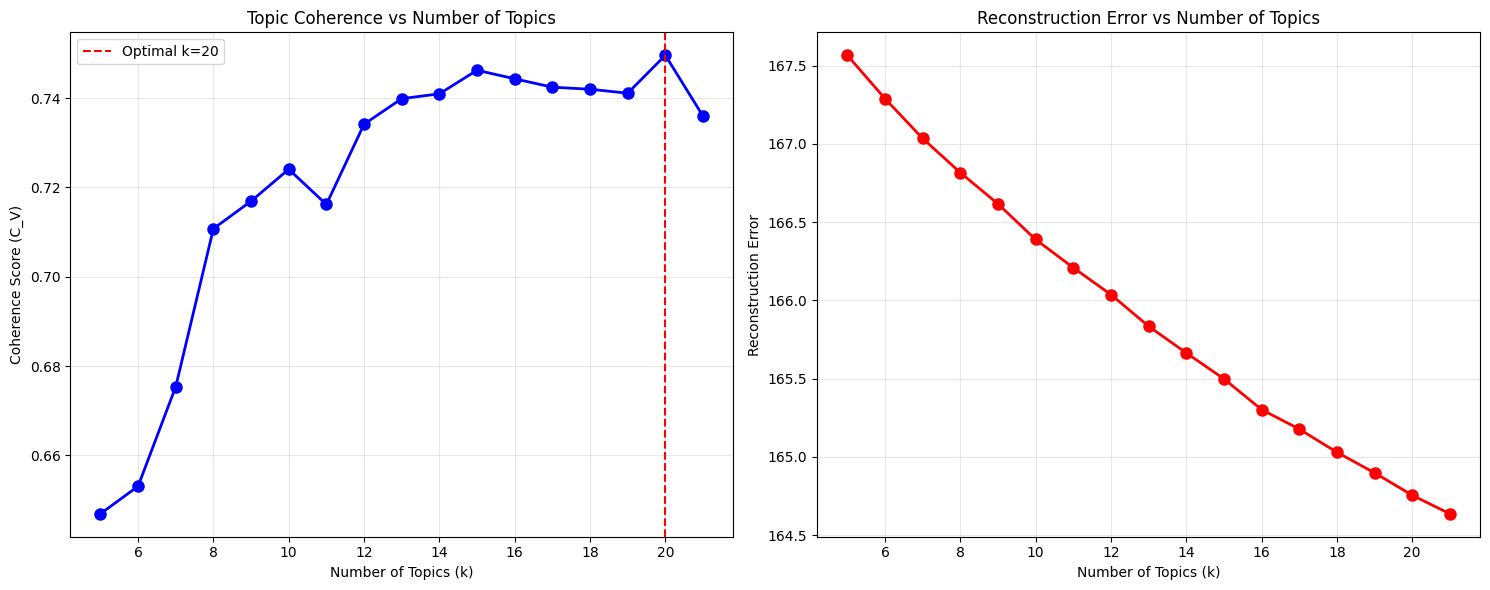

In [ ]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # Fixed: was 'ig' instead of 'fig'

# Plot coherence scores
ax1.plot(k_values, coherence_vals, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Topics (k)')
ax1.set_ylabel('Coherence Score (C_V)')
ax1.set_title('Topic Coherence vs Number of Topics')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=optimal_k_coherence, color='red', linestyle='--',
           label=f'Optimal k={optimal_k_coherence}')
ax1.legend()

# Plot reconstruction errors
ax2.plot(k_values, recon_errors, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Topics (k)')
ax2.set_ylabel('Reconstruction Error')
ax2.set_title('Reconstruction Error vs Number of Topics')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Additional analysis
print(f"\nDetailed Analysis:")
print(f"- Coherence scores range from {min(coherence_vals):.4f} to {max(coherence_vals):.4f}")
print(f"- Reconstruction errors range from {min(recon_errors):.4f} to {max(recon_errors):.4f}")

# Find top 3 k values by coherence
top_3_indices = sorted(range(len(coherence_vals)), key=lambda i: coherence_vals[i], reverse=True)[:3]
print(f"\nTop 3 topic numbers by coherence:")
for i, idx in enumerate(top_3_indices):
    print(f"{i+1}. k={k_values[idx]}: Coherence={coherence_vals[idx]:.4f}, Reconstruction Error={recon_errors[idx]:.4f}")

# Recommendation
print(f"\nRecommendation:")
if best_coherence > 0.5:
    print(f" k={optimal_k_coherence} shows good coherence (>{0.5:.1f})")
else:
    print(f"  All coherence scores are below 0.5. Consider:")
    print("   - Adjusting preprocessing parameters")
    print("   - Different TF-IDF parameters")
    print("   - Alternative topic modeling approach")

print(f"\nYour original choice: k=14")
your_k_idx = k_values.index(14) if 14 in k_values else None
if your_k_idx is not None:
    print(f"k=14 coherence: {coherence_vals[your_k_idx]:.4f}")
    print(f"k=14 reconstruction error: {recon_errors[your_k_idx]:.4f}")
    if k_values[your_k_idx] == optimal_k_coherence:
        print("Selected choice matches the optimal k")
    else:
        print(f"Consider trying k={optimal_k_coherence} for better coherence")


Detailed Analysis:
- Coherence scores range from 0.6469 to 0.7496
- Reconstruction errors range from 164.6361 to 167.5665

Top 3 topic numbers by coherence:
1. k=20: Coherence=0.7496, Reconstruction Error=164.7548
2. k=15: Coherence=0.7463, Reconstruction Error=165.4986
3. k=16: Coherence=0.7443, Reconstruction Error=165.3021

Recommendation:
✅ k=20 shows good coherence (>0.5)

Your original choice: k=14
k=14 coherence: 0.7410
k=14 reconstruction error: 165.6642
💡 Consider trying k=20 for better coherence


In [ ]:
k = 20  # Based on the previous results

# NMF Parameters following best practices:
# - init='nndsvd': Non-negative double singular value decomposition (reproducible initialization)
# - random_state=42: Ensures reproducibility across runs
# - l1_ratio=0.5: Balance between L1 and L2 regularization (promotes sparsity)
# - alpha: Regularization, but it will keep a minimal version
# - max_iter=500: Increased iterations for better convergence

nmf_param = NMF(
    n_components=k,        # Number of topics
    random_state=42,       # Reproducibility
    init='nndsvd',         # Recommended initialization
    l1_ratio=0.5,          # Sparsity control
    # alpha_W=0.1,           # Regularization for W matrix (documents)
    # alpha_H=0.1,           # Regularization for H matrix (topics)
    max_iter=500           # Convergence iterations
)

In [ ]:
# TOPIC MODEL EVALUATION AND VALIDATION
# Add evaluation metrics to assess model quality objectively

# 1. Calculate coherence score (higher is better)
# Convert processed text to gensim format for coherence calculation
def calculate_coherence_score(model, texts, vectorizer):
    """
    Calculate coherence score for NMF model
    Higher scores indicate better topic coherence
    """
    # Get top words for each topic
    feature_names = vectorizer.get_feature_names_out()
    topics = []

    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[-10:]]
        topics.append(top_words)

    # Convert to format needed for coherence calculation
    texts_for_coherence = [text.split() for text in processed_text]
    dictionary = Dictionary(texts_for_coherence)

    # Calculate coherence
    coherence_model = CoherenceModel(
        topics=topics,
        texts=texts_for_coherence,
        dictionary=dictionary,
        coherence='c_v'
    )

    return coherence_model.get_coherence()

print("Model evaluation will be calculated after fitting...")


Model evaluation will be calculated after fitting...


In [ ]:
%%time
nmf_fit = nmf_param.fit(tfidf) # fit method

CPU times: user 35 s, sys: 20.2 s, total: 55.2 s
Wall time: 32.4 s


In [ ]:
# EVALUATE MODEL QUALITY
print("Calculating model evaluation metrics...")

# 1. Coherence Score
try:
    coherence_score = calculate_coherence_score(nmf_fit, processed_text, tfidf_vectorizer)
    print(f"Topic Coherence Score (C_V): {coherence_score:.4f}")
    print("Higher coherence scores indicate more interpretable topics")
except Exception as e:
    print(f"Could not calculate coherence: {e}")

# 2. Reconstruction Error (lower is better)
reconstruction_error = nmf_fit.reconstruction_err_
print(f"Reconstruction Error: {reconstruction_error:.4f}")

# 3. Sparsity measure (proportion of zero values in topic-word matrix)
sparsity = (nmf_fit.components_ == 0).sum() / nmf_fit.components_.size
print(f"Topic-Word Matrix Sparsity: {sparsity:.4f} ({sparsity*100:.1f}% zeros)")

print("\nModel Quality Assessment:")
print("- Coherence > 0.5: Good topic interpretability")
print("- Sparsity 0.7-0.9: Good balance between specificity and coverage")
print("- Lower reconstruction error indicates better fit to data")

Calculating model evaluation metrics...
Topic Coherence Score (C_V): 0.7496
Higher coherence scores indicate more interpretable topics
Reconstruction Error: 164.7548
Topic-Word Matrix Sparsity: 0.7337 (73.4% zeros)

Model Quality Assessment:
- Coherence > 0.5: Good topic interpretability
- Sparsity 0.7-0.9: Good balance between specificity and coverage
- Lower reconstruction error indicates better fit to data


In [ ]:
nmf_weights = nmf_fit.components_

In [ ]:
# Function do display topics  words and their weights
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index]) for wt, index in zip(weights, sorted_indices)])
    sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])
    topics = [np.vstack((terms.T, term_weights.T)).T for terms, term_weights in zip(sorted_terms, sorted_weights)]
    return topics

In [ ]:
# Function to print components of all the topics
def print_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     display_weights=False,
                     num_terms=None):

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, wt,2)
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]

        if display_weights:
            print('Topic #'+str(index+1)+' with weights')
            print(topic[:num_terms]) if num_terms else topic
        else:
            print('Topic #'+str(index+1)+' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else tw

In [ ]:
# Function to print topic terms
def get_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     num_terms=None):
    topic_terms = []
    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, wt,2)
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]
        topic_terms.append(topic[:num_terms] if num_terms else topic)
    return topic_terms

In [ ]:
# Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
%%time
# Show NMF topics with their weights
topics = get_topics_terms_weights(nmf_weights, tfidf_feature_names)
print_topics_udf(topics, total_topics=k, num_terms=10, display_weights=True)

Topic #1 with weights
[('fat', 3.026622905139271, 2), ('body', 1.9629490044882856, 2), ('mass', 1.7446586088078253, 2), ('composition', 1.4751541439609974, 2), ('measure', 1.1041848682536786, 2), ('adiposity', 1.097668511960066, 2), ('abdominal', 0.8684907193299393, 2), ('visceral', 0.8559934710037572, 2), ('total', 0.8438928429906043, 2), ('index', 0.8054350555771307, 2)]
Topic #2 with weights
[('surgery', 2.1290473224579016, 2), ('bariatric', 1.9017381267606297, 2), ('patient', 1.151020046958426, 2), ('undergo', 0.5325543072639838, 2), ('post', 0.4190447676065021, 2), ('surgical', 0.3925559892228359, 2), ('postoperative', 0.34584643580319824, 2), ('preoperative', 0.322020454210936, 2), ('follow', 0.29484685299381685, 2), ('pre', 0.25415009592661303, 2)]
Topic #3 with weights
[('expression', 1.3404089246443178, 2), ('adipose_tissue', 0.9619993998864275, 2), ('adipocyte', 0.8861066966843476, 2), ('cell', 0.7806494542767297, 2), ('gene', 0.723741970005736, 2), ('human', 0.69184138706920

In [ ]:
# Create Document-Topic Matrix for NMF
nmf_output = nmf_fit.transform(tfidf)
# Which is basically the same as:
# nmf_output = nmf_model.fit_transform(tfidf)

In [ ]:
###########################################
### NMF - DOMINANT TOPIC IN EACH RECORD ###
###########################################

# Column names
nmf_topic_names = ["NMF_Topic_" + str(i) for i in range(k)]

# Index names
doc_id = ["Doc_" + str(i) for i in range(len(df['abstract']))]

# We build a Pandas data frame
nmf_topics_df = pd.DataFrame(np.round(nmf_output, 2), columns=nmf_topic_names, index=doc_id)

# Get dominant topic for each document
nmf_topic = np.argmax(nmf_topics_df.values, axis=1)

# Populating columns
nmf_topics_df['nmf_topic'] = nmf_topic

In [ ]:
# Some color for our dataframe
def red_color(val):
    color = 'red' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

# Some color for our dataframe
def blue_color(val):
    color = 'blue' if val > 0 else 'black'
    return 'color: {col}'.format(col=color)

def bolder(val):
    weight = 650 if val > 0 else 350
    return 'font-weight: {weight}'.format(weight=weight)

# Applying this color to our data frame
NMF_df_dominant_topics = nmf_topics_df.head(15).style.applymap(blue_color).applymap(bolder)

<ipython-input-30-26e30133ac33>:16: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  NMF_df_dominant_topics = nmf_topics_df.head(15).style.applymap(blue_color).applymap(bolder)


In [ ]:
# Show data frame with dominant topic columns
NMF_df_dominant_topics

,NMF_Topic_0,NMF_Topic_1,NMF_Topic_2,NMF_Topic_3,NMF_Topic_4,NMF_Topic_5,NMF_Topic_6,NMF_Topic_7,NMF_Topic_8,NMF_Topic_9,NMF_Topic_10,NMF_Topic_11,NMF_Topic_12,NMF_Topic_13,NMF_Topic_14,NMF_Topic_15,NMF_Topic_16,NMF_Topic_17,NMF_Topic_18,NMF_Topic_19,nmf_topic
Doc_0,0.010000,0.000000,0.000000,0.020000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.020000,0.030000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,12
Doc_1,0.000000,0.030000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,1
Doc_2,0.020000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.060000,0.000000,0.010000,17
Doc_3,0.010000,0.010000,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,14
Doc_4,0.000000,0.000000,0.000000,0.000000,0.010000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,5
Doc_5,0.000000,0.010000,0.000000,0.000000,0.030000,0.010000,0.010000,0.000000,0.000000,0.020000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.100000,0.010000,0.000000,17
Doc_6,0.010000,0.000000,0.000000,0.000000,0.010000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12
Doc_7,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
Doc_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.020000,0.010000,0.000000,0.000000,0.010000,0.030000,0.000000,6
Doc_9,0.000000,0.000000,0.000000,0.000000,0.020000,0.020000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,8


In [ ]:
df_nmf_topic_distribution = nmf_topics_df['nmf_topic'].value_counts().reset_index(name="Number of Documents")
df_nmf_topic_distribution.columns = ['NMF Topic Number', 'Number of Documents']
df_nmf_topic_distribution

,NMF Topic Number,Number of Documents
0,1,3028
1,19,2404
2,3,2174
3,4,2107
4,2,2077
5,5,2017
6,12,1682
7,8,1476
8,9,1444
9,14,1443


In [ ]:
# Function to show top n keywords for each topic:
def show_topics(model, features, words):
    keywords = np.array(features)
    topic_keywords = []
    for topic_weights in model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [ ]:
nmf_topic_keywords = show_topics(nmf_fit, tfidf_feature_names, 10)

# NMF Topic-Keywords Dataframe
df_nmf_topic_keywords = pd.DataFrame(nmf_topic_keywords)
df_nmf_topic_keywords.columns = ['Keyword_'+str(i+1) for i in range(df_nmf_topic_keywords.shape[1])]
df_nmf_topic_keywords.index = ['NMF_Topic_'+str(i+1) for i in range(df_nmf_topic_keywords.shape[0])]
df_nmf_topic_keywords

,Keyword_1,Keyword_2,Keyword_3,Keyword_4,Keyword_5,Keyword_6,Keyword_7,Keyword_8,Keyword_9,Keyword_10
NMF_Topic_1,fat,body,mass,composition,measure,adiposity,abdominal,visceral,total,index
NMF_Topic_2,surgery,bariatric,patient,undergo,post,surgical,postoperative,preoperative,follow,pre
NMF_Topic_3,expression,adipose_tissue,adipocyte,cell,gene,human,mrna,role,protein,inflammation
NMF_Topic_4,loss,weight,month,change,kg,baseline,group,intervention,lose,participant
NMF_Topic_5,health,intervention,care,management,prevention,strategy,policy,review,provide,public
NMF_Topic_6,child,girl,boy,childhood,parent,year,adolescent,age,school,bmi
NMF_Topic_7,diet,rat,mouse,feed,week,fat,hfd,induce,high,group
NMF_Topic_8,maternal,pregnancy,birth,mother,gestational,infant,gain,offspring,early,gwg
NMF_Topic_9,intake,food,energy,dietary,consumption,meal,consume,day,eat,carbohydrate
NMF_Topic_10,eat,self,report,eating,behavior,life,quality,depression,questionnaire,score


<b>TOPIC EVOLUTION OVER TIME (TRENDS)</b>

In [ ]:
nmf_topics_df['Timestamp'] = pd.to_datetime(df['year'].values, format='%Y') #%Y%m%d%H%M%S

In [ ]:
nmf_topics_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29922 entries, Doc_0 to Doc_29921
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   NMF_Topic_0   29922 non-null  float64       
 1   NMF_Topic_1   29922 non-null  float64       
 2   NMF_Topic_2   29922 non-null  float64       
 3   NMF_Topic_3   29922 non-null  float64       
 4   NMF_Topic_4   29922 non-null  float64       
 5   NMF_Topic_5   29922 non-null  float64       
 6   NMF_Topic_6   29922 non-null  float64       
 7   NMF_Topic_7   29922 non-null  float64       
 8   NMF_Topic_8   29922 non-null  float64       
 9   NMF_Topic_9   29922 non-null  float64       
 10  NMF_Topic_10  29922 non-null  float64       
 11  NMF_Topic_11  29922 non-null  float64       
 12  NMF_Topic_12  29922 non-null  float64       
 13  NMF_Topic_13  29922 non-null  float64       
 14  NMF_Topic_14  29922 non-null  float64       
 15  NMF_Topic_15  29922 non-null  flo

In [ ]:
nmf_topics_df['Timestamp'].min(), nmf_topics_df['Timestamp'].max()

(Timestamp('2000-01-01 00:00:00'), Timestamp('2023-01-01 00:00:00'))

In [ ]:
nmf_topics_df = nmf_topics_df.sort_values('Timestamp')

In [ ]:
nmf_topics_df.isnull().sum()

,0
NMF_Topic_0,0
NMF_Topic_1,0
NMF_Topic_2,0
NMF_Topic_3,0
NMF_Topic_4,0
NMF_Topic_5,0
NMF_Topic_6,0
NMF_Topic_7,0
NMF_Topic_8,0
NMF_Topic_9,0


In [ ]:
# Dataframe topics names list
df_topic_names = ['topic_' + str(i) + '_df' for i in range(k)]

for i in range(k):
    df_topic_names[i] = nmf_topics_df.groupby('Timestamp')[nmf_topic_names[i]].sum().reset_index()
    df_topic_names[i] = df_topic_names[i].set_index('Timestamp')

In [ ]:
y_list = ['y' + str(i) for i in range(k)]
for i in range(k):
    y_list[i] = df_topic_names[i][nmf_topic_names[i]]

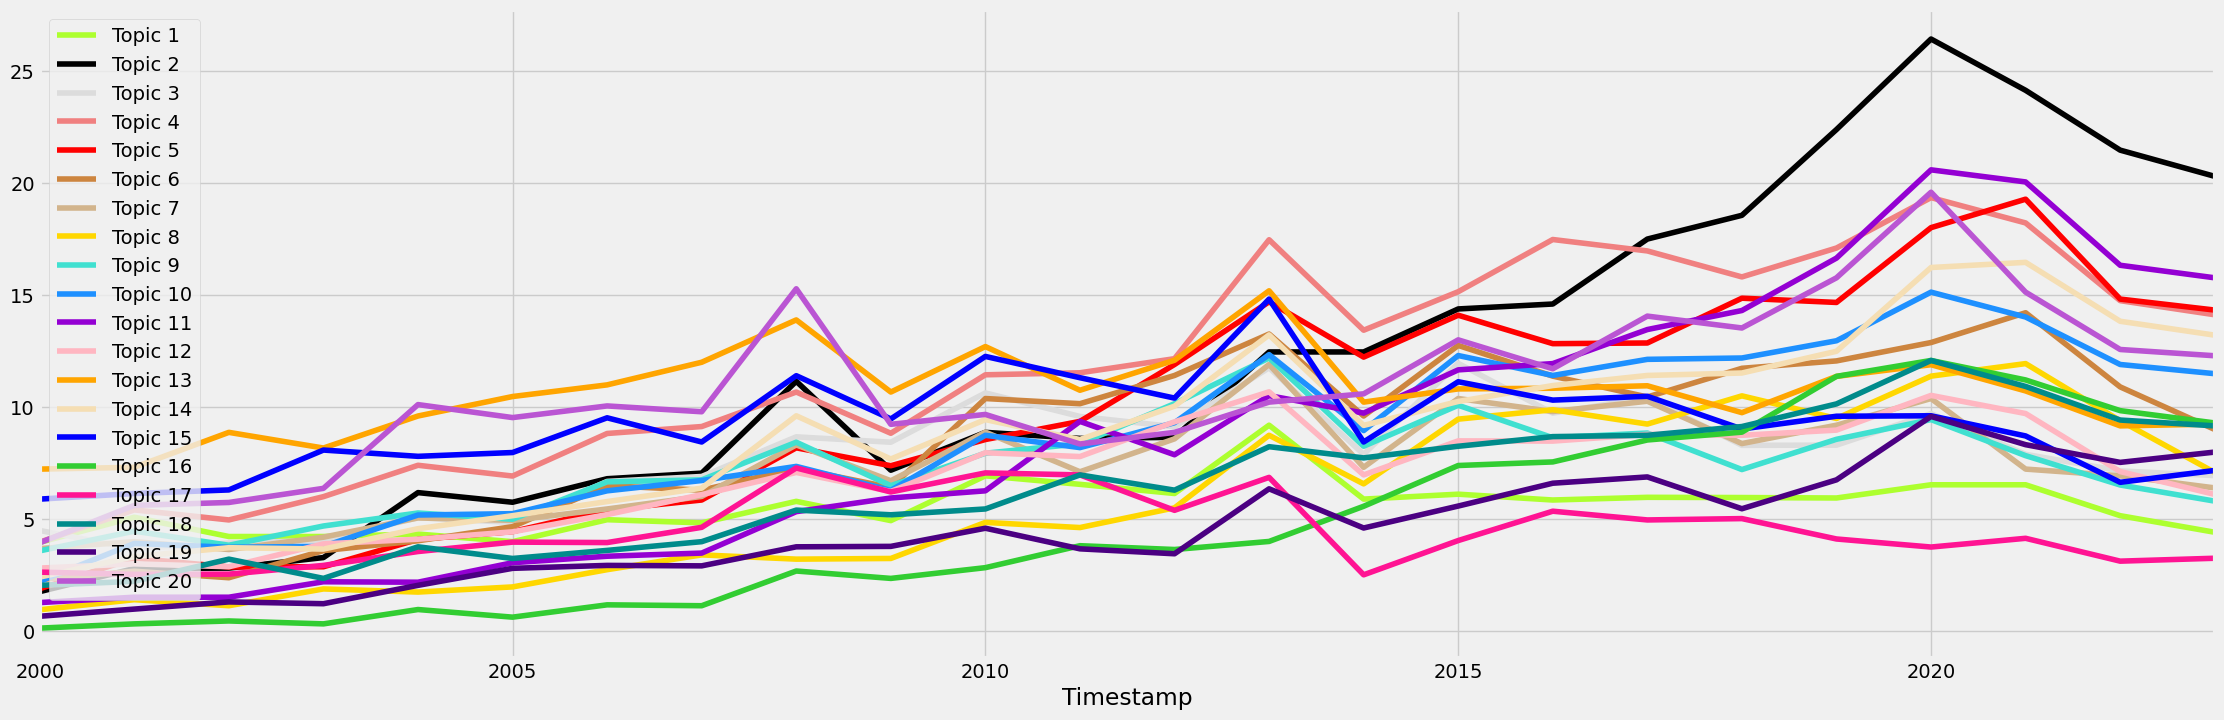

In [ ]:
# Plot style
plt.style.use('fivethirtyeight')

for i in range(k):
    topic_label = 'Topic ' + str(i+1)
    colors = [
    'greenyellow', 'black', 'gainsboro', 'lightcoral', 'red', 'peru', 'tan',
    'gold', 'turquoise', 'dodgerblue', 'darkviolet', 'lightpink', 'orange',
    'wheat', 'blue', 'limegreen', 'deeppink', 'darkcyan', 'indigo', 'mediumorchid'
    ]
    y_list[i].plot(figsize=(25, 8), label=topic_label, color=colors[i])
plt.legend()
# Show plot
figname = os.path.join(output_dir, 'obesity_literature_topic_trends.tiff')
plt.savefig(figname, format="tiff", dpi=600)
plt.show()